<a href="https://colab.research.google.com/github/Knightler/PyTorch-projects/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install opendatasets --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/animal-faces')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aryanhaghighi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:16<00:00, 42.9MB/s]


In [8]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
image_path = []
labels = []

for i in os.listdir('/content/animal-faces/afhq'):
    for label in os.listdir(f'/content/animal-faces/afhq/{i}'):
        for image in os.listdir(f'/content/animal-faces/afhq/{i}/{label}'):
            image_path.append(f'/content/animal-faces/afhq/{i}/{label}/{image}')
            labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_path', 'labels'])

print(data_df['labels'].unique())
data_df.head()

['wild' 'cat' 'dog']


,image_path,labels
0,/content/animal-faces/afhq/train/wild/flickr_w...,wild
1,/content/animal-faces/afhq/train/wild/pixabay_...,wild
2,/content/animal-faces/afhq/train/wild/flickr_w...,wild
3,/content/animal-faces/afhq/train/wild/flickr_w...,wild
4,/content/animal-faces/afhq/train/wild/flickr_w...,wild


In [10]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(val.shape)
print(test.shape)

(11291, 2)
(2420, 2)
(2419, 2)


In [11]:
label_encoder = LabelEncoder()

label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [13]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

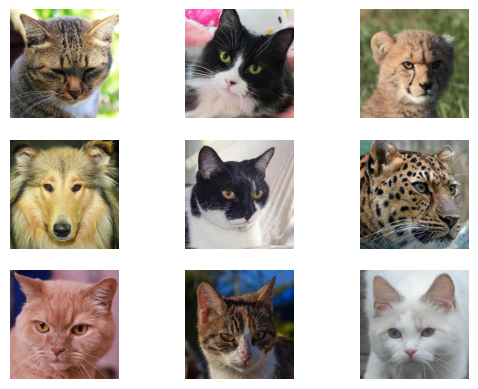

In [14]:
n_rows = 3
n_cols = 3

f, ax = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
        ax[row, col].imshow(image)
        ax[row, col].axis('off')
plt.show()

In [15]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.polling = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(data_df['labels'].unique()))

    def forward(self, x):
        x = self.conv1(x) # -> (32, 128, 128)
        x = self.polling(x) # -> (32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) # -> (64, 64, 64)
        x = self.polling(x) # -> (64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) # -> (128, 32, 32)
        x = self.polling(x) # -> (128, 16, 16)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [18]:
model = Net().to(device)

In [19]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [21]:
total_loss_train_plot = []
total_acc_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_acc_train = 0
    total_loss_val = 0
    total_acc_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()

        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_val_plot.append(round(total_loss_val/1000, 4))

    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_val_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/1000, 4)}, Train Accuracy {round(total_acc_train/train_dataset.__len__()*100, 4)}
          Validation Loss: {round(total_loss_val/1000, 4)}, Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}
    ''')

Epoch 1/10, Train Loss: 0.3491, Train Accuracy 79.2312
          Validation Loss: 0.0453, Validation Accuracy: 88.3884
    
Epoch 2/10, Train Loss: 0.1414, Train Accuracy 92.8439
          Validation Loss: 0.0392, Validation Accuracy: 90.2479
    
Epoch 3/10, Train Loss: 0.0926, Train Accuracy 95.2617
          Validation Loss: 0.023, Validation Accuracy: 94.6694
    
Epoch 4/10, Train Loss: 0.0648, Train Accuracy 96.8028
          Validation Loss: 0.0188, Validation Accuracy: 95.5372
    
Epoch 5/10, Train Loss: 0.0538, Train Accuracy 97.3873
          Validation Loss: 0.0204, Validation Accuracy: 95.2066
    
Epoch 6/10, Train Loss: 0.0381, Train Accuracy 98.2375
          Validation Loss: 0.0229, Validation Accuracy: 95.0826
    
Epoch 7/10, Train Loss: 0.0294, Train Accuracy 98.4855
          Validation Loss: 0.0228, Validation Accuracy: 94.7521
    
Epoch 8/10, Train Loss: 0.0215, Train Accuracy 99.0081
          Validation Loss: 0.0215, Validation Accuracy: 95.5372
    
Epoch 9/1

In [23]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)

        acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += acc
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

    print(f'Accuracy Score: {round(total_acc_test/test_dataset.__len__()*100, 4)}, Test Loss: {round(total_loss_test/1000, 4)}')

Accuracy Score: 96.0728, Test Loss: 0.0197


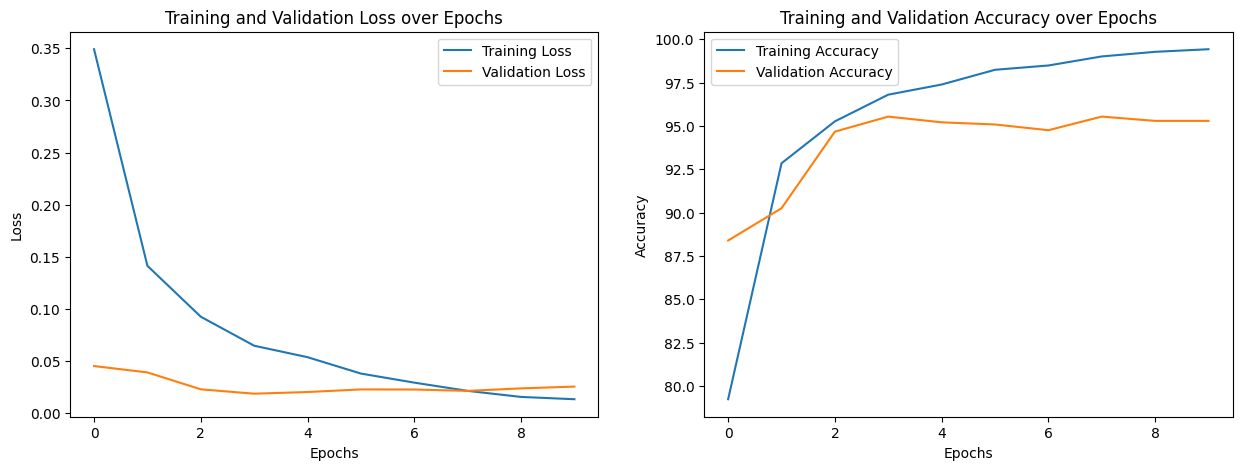

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [39]:
# 1. Read image
# 2. Transform using transform object
# 3. Predict through the model
# 4. Inverse transform by label encoder

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).to(device)
    print(image.unsqueeze(0).shape)
    print(image.shape)
    output = model(image.unsqueeze(0))
    output = torch.argmax(output, axis=1).item()
    return label_encoder.inverse_transform([output])

In [43]:
predict_image('/content/kitty-cat-kitten-pet-45201.jpeg')

torch.Size([1, 3, 128, 128])
torch.Size([3, 128, 128])


array(['dog'], dtype=object)